In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from apyori import apriori

import datetime

import statsmodels.api as sm

from scipy.stats import spearmanr 

from sklearn.impute import SimpleImputer

from scipy.spatial.distance import cdist 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import joblib
from sklearn.metrics import r2_score 

from math import radians, cos, sin, asin, sqrt

imp_df = pd.read_csv('./dataset_w_weather&rwi.csv')
imp_df.head(5)

,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,...,buyDrinks,TotalSpent_RM,latitude,longitude,Num_of_Baskets,weather,Day,Month,Year,rwi
0,19/10/2015,Evening,malay,male,moderate,28.0,yes,young,big,red,...,2.0,9.0,2.912316,101.657948,1.0,Clear,Monday,October,2015,0.912
1,19/10/2015,Evening,malay,female,moderate,30.0,no,no_kids,big,blue,...,2.0,13.0,2.935533,101.737170,1.0,Clear,Monday,October,2015,0.817
2,19/10/2015,Evening,indian,male,thin,51.0,no,no_kids,small,black,...,2.0,16.0,2.949924,101.637069,1.0,Clear,Monday,October,2015,0.653
3,19/10/2015,Evening,indian,male,moderate,34.0,no,no_kids,big,blue,...,1.0,13.0,2.903530,101.661249,3.0,Clear,Monday,October,2015,0.912
4,20/10/2015,Night,indian,male,thin,49.0,no,no_kids,big,blue,...,0.0,16.0,2.951176,101.746526,3.0,Clear,Tuesday,October,2015,0.845


In [17]:
# Feature Selection

def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))
  
fs_df = imp_df.copy()
fs_df = fs_df.apply(LabelEncoder().fit_transform)

X = fs_df.drop(['TotalSpent_RM'], axis=1)
y = fs_df['TotalSpent_RM']
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=1)
feat_selector.fit(X.values, y.values.ravel())
boruta_score = ranking(list(map(float, feat_selector.ranking_)), X.columns, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

print('---------Top 10----------')
display(boruta_score.head(10))

print('---------Bottom 10----------')
display(boruta_score.tail(10))

sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[:10], kind = "bar", height=14, aspect=2, palette='coolwarm')
plt.title("Boruta Top 10 Features")
sns_boruta_plot.figure.savefig('TotalSpent_Boruta.png')

pd.DataFrame.to_csv(boruta_score.head(10), 'Baskets_Boruta_Top10.csv')

AttributeError: module 'numpy' has no attribute 'int'

In [18]:
mvlrX = imp_df[['rwi', 'TimeSpent_minutes', 'Age_Range', 'Basket_colour', 'Pants_Colour', 'TotalSpent_RM']]
mvlrX = mvlrX.apply(LabelEncoder().fit_transform)

train = mvlrX.sample(frac=0.8, random_state=1)
test = mvlrX.loc[~imp_df.index.isin(train.index)]

print(train.shape)
print(test.shape)

(2918, 6)
(730, 6)


In [19]:
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train.drop(['TotalSpent_RM'], axis=1))
train_y = np.asanyarray(train[['TotalSpent_RM']])
lm = regr.fit(train_x,train_y)  

print ("coefficients : ",regr.coef_) #Slope
print ("Intercept : ",regr.intercept_)

lm.score(train_x,train_y)

coefficients :  [[0.00264566 0.00263506 0.00511742 0.0354202  0.03234649]]
Intercept :  [7.10644346]


0.0027555516352542053

In [20]:
def get_regression_predictions(input_features,intercept,slope):
    predicted_values = input_features*slope + intercept
    return predicted_values

# Checking various accuracy:
from sklearn.metrics import r2_score 
test_x = np.array(test.drop(['TotalSpent_RM'], axis=1))
test_y = np.array(test[['TotalSpent_RM']])
test_y_ = regr.predict(test_x)
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Mean sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y)** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

Mean absolute error: 3.70
Mean sum of squares (MSE): 18.71
R2-score: -372.23


In [21]:
rwi = 1
TimeSpent_minutes = 10
Age_Range = 10
Basket_colour = 1
Pants_Colour = 1

custom_input = np.array([rwi, TimeSpent_minutes, Age_Range, Basket_colour, Pants_Colour])

predicted_value = lm.predict(custom_input.reshape(1, -1))
print("Predicted value: ", predicted_value)


Predicted value:  [[7.25438067]]


In [22]:
model = sm.OLS(train_y, train_x).fit()
predictions = model.predict(test_x)
model.summary ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.723
Model:                            OLS   Adj. R-squared (uncentered):              0.722
Method:                 Least Squares   F-statistic:                              1518.
Date:                Sat, 14 Jan 2023   Prob (F-statistic):                        0.00
Time:                        05:05:34   Log-Likelihood:                         -8692.9
No. Observations:                2918   AIC:                                  1.740e+04
Df Residuals:                    2913   BIC:                                  1.743e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0240      0.002     12.557      0.000       0.020       0.028
x2             0.0547      0.005     10.068      0.000       0.044       0.065
x3             0.0777      0.006     12.258      0.000       0.065       0.090
x4             0.2620      0.025     10.682      0.000       0.214       0.310
x5             0.1661      0.018      9.062      0.000       0.130       0.202
==============================================================================
Omnibus:                      283.355   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.058
Skew:                           0.003   Prob(JB):                     5.58e-19
Kurtosis:                       2.169   Cond. No.                         26.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# make predictions
expected = test_y
predicted = model.predict(test_x)

# make a single prediction
rwi = 1.5
TimeSpent_minutes = 30
Age_Range = 20
Basket_colour = 1
Pants_Colour = 1
 
custom_input = np.array([rwi, TimeSpent_minutes, Age_Range, Basket_colour, Pants_Colour])
predicted_value = model.predict(custom_input.reshape(1, -1))

print("Predicted value: ", predicted_value)

Predicted value:  [3.6576838]


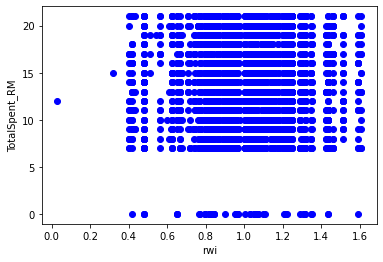

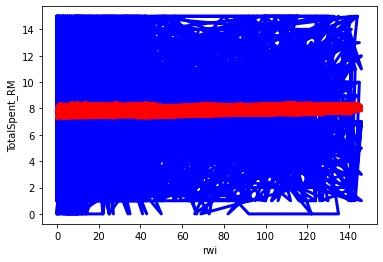

In [24]:
# plot rwi vs TotalSpent_RM
plt.scatter(imp_df['rwi'], imp_df['TotalSpent_RM'], color='blue')
plt.xlabel("rwi")
plt.ylabel("TotalSpent_RM")
plt.show()

plt.plot(test_x, test_y, color='blue', linewidth=3)
plt.plot(test_x, test_y_, color='red', linewidth=3)
plt.xlabel("rwi")
plt.ylabel("TotalSpent_RM")
plt.show()

In [25]:
regressor = SVR(kernel = 'rbf')

regressor.fit(train_x, train_y)
y_pred = regressor.predict(test_x)

print("Mean Absolute Error: {:.3f}".format(mean_absolute_error(test_y, y_pred)))
print("Mean Squared Error: {:.3f}".format(mean_squared_error(test_y, y_pred)))

/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 3.713
Mean Squared Error: 18.873


/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

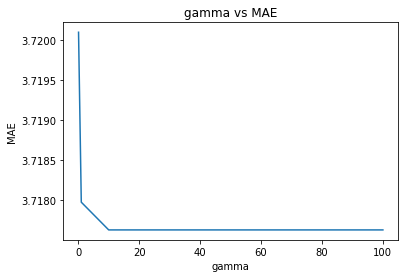

In [26]:
gammas = [0.1, 1, 10, 100]
svr_mae = [] 
for gamma in gammas:
    svr = SVR(kernel = 'rbf', gamma = gamma)
    svr.fit(train_x, train_y)
    svr_y_pred = svr.predict(test_x)
    svr_mae.append(mean_absolute_error(test_y, svr_y_pred))
    
plt.plot(gammas, svr_mae)
plt.xlabel('gamma')
plt.ylabel('MAE')
plt.title('gamma vs MAE').figure.savefig('gamma_vs_mae.png') 
plt.show()

/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

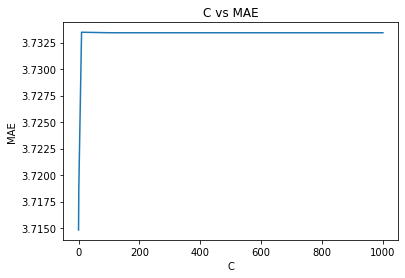

In [27]:
cs = [0.1, 1, 10, 100, 1000]
svr_mae = [] 
for c in cs:
    svr = SVR(kernel = 'rbf', C=c, gamma = 'auto')
    svr.fit(train_x, train_y)
    svr_y_pred = svr.predict(test_x)
    svr_mae.append(mean_absolute_error(test_y, svr_y_pred))
    
plt.plot(cs, svr_mae)
plt.xlabel('C')
plt.ylabel('MAE')
plt.title('C vs MAE').figure.savefig('c_vs_mae.png') 
plt.show()